In [67]:
#imports all helper functions used from functions.py
#/workspaces/ACT-Coursework-2/py/functions.py
#from py.functions import *

#imports
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt

#all helper functions used
path = kagglehub.dataset_download("bryancimo/sdss-galaxy-classification-dr18")
print(path)
def data_grabber():
    data = pd.read_csv(path)
    return data

data = data_grabber()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data.head()

/home/codespace/.cache/kagglehub/datasets/bryancimo/sdss-galaxy-classification-dr18/versions/1


IsADirectoryError: [Errno 21] Is a directory: '/home/codespace/.cache/kagglehub/datasets/bryancimo/sdss-galaxy-classification-dr18/versions/1'

In [ ]:
#main feature trying to find is subclass (starforming or starburst)
features = data[['ra', 'dec', 'subclass','u', 'g', 'r', 'i', 'z', 'redshift']]
target = data['subclass']

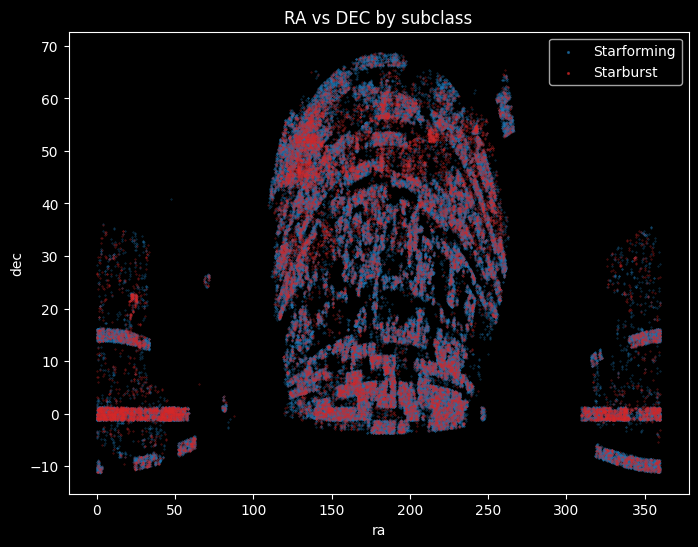

In [ ]:
subs = data['subclass'].fillna('Unknown').astype(str).str.lower()
colors = {'starforming':'tab:blue', 'starburst':'tab:red', 'unknown':'grey'}
plt.figure(figsize=(8,6))
for cls in subs.unique():
    mask = subs == cls
    plt.scatter(data.loc[mask, 'ra'], data.loc[mask, 'dec'], s=0.1, alpha=0.6,
                label=cls.capitalize(), color=colors.get(cls, 'grey'))
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend(markerscale=4)
plt.title('RA vs DEC by subclass')
plt.style.use('dark_background')
plt.show()